In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

/Users/congliu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%load_ext watermark
%watermark -v -p numpy,torch

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
torch 1.4.0


In [2]:
torch.manual_seed(42)
np.random.seed(42)

%matplotlib inline
sns.set_style('darkgrid')

In [3]:
n10 = pd.read_csv('/Users/congliu/prs/lasso_data/m2_otu_std.txt', 
                  sep='\t').drop('OTU ID', axis=1)
n10 = n10.fillna(0)
nt = n10.T
nt.columns = nt.loc['taxonomy']
nt.drop('taxonomy', inplace=True)
def cc(x, min_x):
    if x >= min_x:
        x = x
    else:
        x = 0
    return x
        
def change_small_zero(x):
    x.replace(0.0, np.nan, inplace=True)
    min_x = 5 * x.min(skipna=True)
    x.replace(np.nan, 0, inplace=True)
    hehe = x.apply(cc, args=(min_x,))
    
    return hehe
    
#nt = nt.apply(change_small_zero, axis=1)
#nt.loc['new_row'] = 1 - (nt.isin([0]).sum(axis=0) / nt.shape[0])
#dd = nt.loc['new_row'] <= 0.05
#nt.drop(dd[dd == True].index.to_list(), axis=1, inplace=True)
#nt.drop('new_row', inplace=True)
new_mapfile = pd.read_csv('/Users/congliu/prs/lasso_data/map_20200108_add_ref_n_a_c.txt', 
                          sep='\t').drop(['#SampleID', 'BarcodeSequence', 'LinkerPrimerSequence','source'], axis=1)
dataset = nt.merge(new_mapfile, left_on=nt.index, right_on='Description')
dataset = dataset[(dataset['Type'] == 'c')|(dataset['Type'] == 'n')]
dataset.drop('Unassigned', axis=1, inplace=True)
#dataset['Type'].replace({'c':1, 'n':0}, inplace=True)
dataframe = dataset.drop('Description', axis=1)

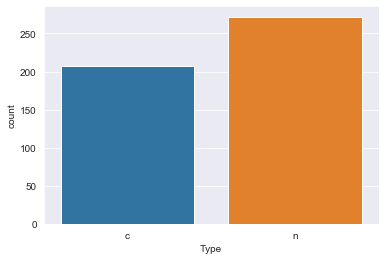

In [4]:
# 数据探索
sns.countplot(data = dataframe, x = 'Type')

In [5]:
dataframe['Type'] = dataframe['Type'].astype('category')
#dataframe = dataframe.astype('int')
encode_map = {
    'c': 1,
    'n': 0
}

dataframe['Type'].replace(encode_map, inplace=True)

X = dataframe.iloc[:, 0:-1]
y = dataframe.iloc[:, -1]

#X = torch.from_numpy(X).type(torch.FloatTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [6]:
# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# 统计各个数据中的分类分布
def get_class_distribution(obj):
    count_dict = {
        "cancer": 0,
        "normal": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['normal'] += 1
        elif i == 1: 
            count_dict['cancer'] += 1
        else:
            print("Check classes.")
            
    return count_dict

print("Train: ", get_class_distribution(y_train))
print("Test: ", get_class_distribution(y_test))
print("Val: ", get_class_distribution(y_val))
print(X_train.shape, X_val.shape, X_test.shape)

Train:  {'cancer': 139, 'normal': 184}
Test:  {'cancer': 52, 'normal': 68}
Val:  {'cancer': 16, 'normal': 20}


In [7]:
# train data, pytorch所需的数据输入格式
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


# train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
# train_data = trainData(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

        
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
train_data = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())

# test data
class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    def __getitem__(self, index):
        return self.X_data[index]
    def __len__(self):
        return len(self.X_data)

# test_data = TestData(torch.FloatTensor(X_test))
test_data = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [8]:
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.001


# Weighted Sampling
target_list = []

for _, t in train_data:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)


# initialize dataloader

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=weighted_sampler)
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

tensor([0.0072, 0.0054])


In [9]:
# create a module
# what is a Dense
class binaryClassification(nn.Module):
    def __init__(self):
        super().__init__()
        # Number of input features is 3135
        self.layer_1 = nn.Linear(3135, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_out = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x


class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(3135, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 2)

    def forward(self, inputs):
        # output of the first layer
        x = self.layer_1(inputs)
        x = F.tanh(x)
        x = self.layer_2(x)
        x = F.Dropout(x)

        return x
    def predict(self, x):
        pred = F.softmax(self.forward(x))
        ans = []
        for i in pred:
            if t[0] > t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
print(device)
model = binaryClassification()
model.to(device)
print(model)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

cpu
binaryClassification(
  (layer_1): Linear(in_features=3135, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [11]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        # 模型和数据在同一设备
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        # 清除网络状态
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.56316 | Val Loss: 0.69862 | Train Acc: 68.667| Val Acc: 50.000
Epoch 002: | Train Loss: 0.37119 | Val Loss: 0.68340 | Train Acc: 86.333| Val Acc: 55.556
Epoch 003: | Train Loss: 0.21980 | Val Loss: 0.66160 | Train Acc: 94.000| Val Acc: 61.111
Epoch 004: | Train Loss: 0.14293 | Val Loss: 0.64655 | Train Acc: 98.000| Val Acc: 66.667
Epoch 005: | Train Loss: 0.10130 | Val Loss: 0.64381 | Train Acc: 98.667| Val Acc: 58.333
Epoch 006: | Train Loss: 0.05459 | Val Loss: 0.66272 | Train Acc: 99.667| Val Acc: 58.333
Epoch 007: | Train Loss: 0.03997 | Val Loss: 0.69895 | Train Acc: 99.667| Val Acc: 58.333
Epoch 008: | Train Loss: 0.03347 | Val Loss: 0.75549 | Train Acc: 100.000| Val Acc: 55.556
Epoch 009: | Train Loss: 0.02254 | Val Loss: 0.81166 | Train Acc: 100.000| Val Acc: 58.333
Epoch 010: | Train Loss: 0.01286 | Val Loss: 0.87391 | Train Acc: 100.000| Val Acc: 58.333
Epoch 011: | Train Loss: 0.00972 | Val Loss: 0.92135 | Train Acc: 100.000| Val Acc: 58.333
Epoch 

In [ ]:
model = BinaryClassification()
def train_module(EPOCH):
    print('training begin')
    losses = []
    for i in range(EPOCH):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred)
        losses.append(loss.item())
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

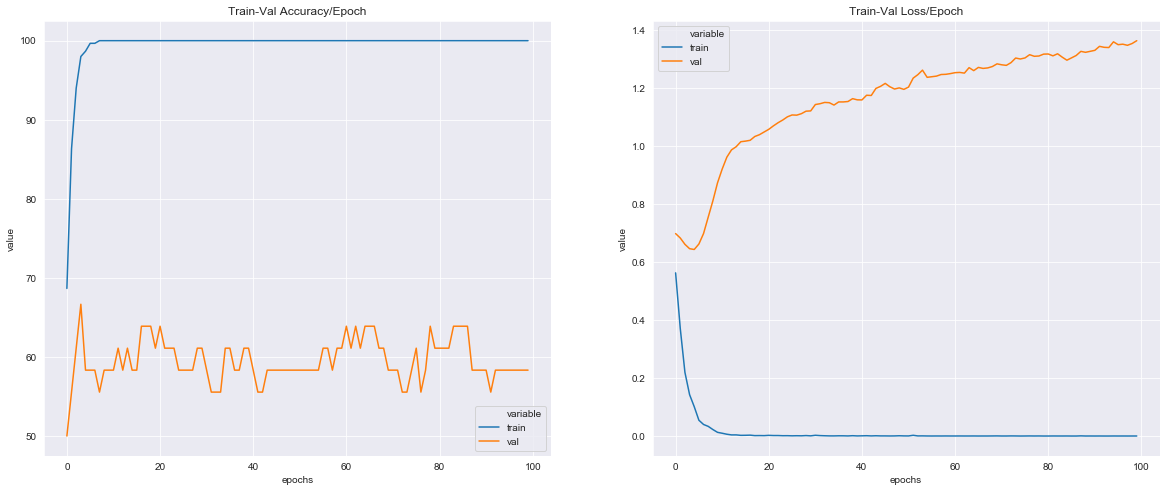

In [12]:
# Visualize Loss and Accuracy
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

precision    recall  f1-score   support

      Normal       0.72      0.72      0.72        68
      Cancer       0.63      0.63      0.63        52

    accuracy                           0.68       120
   macro avg       0.68      0.68      0.68       120
weighted avg       0.68      0.68      0.68       120



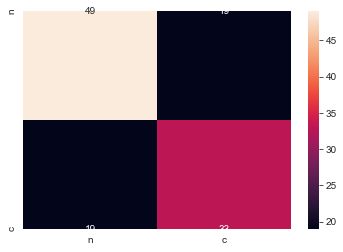

In [27]:
idx2class = {v: k for k, v in encode_map.items()}
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test, y_pred_list, target_names=["Normal", "Cancer"]))